In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/maildata_cleaned.csv")

df = df.dropna(subset=["clean_text", "Category"])
df = df[df["clean_text"].str.strip() != ""]

X = df["clean_text"]
y = df["Category"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_vect, y_train)



MultinomialNB(alpha=0.1)


Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       902
        spam       0.97      0.89      0.93       128

    accuracy                           0.98      1030
   macro avg       0.98      0.94      0.96      1030
weighted avg       0.98      0.98      0.98      1030

Accuracy: 0.9835


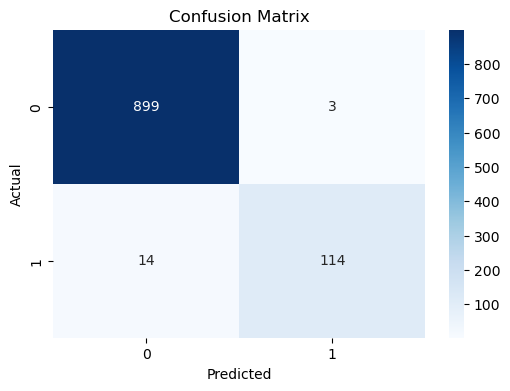

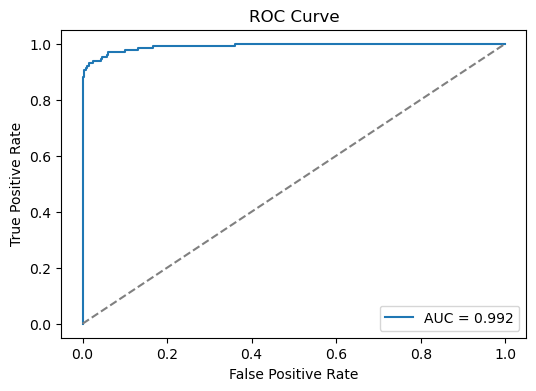

In [5]:

model = nb_model

y_pred = model.predict(X_test_vect)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob = model.predict_proba(X_test_vect)[:,1]
roc_auc = roc_auc_score((y_test=="spam").astype(int), y_prob)
fpr, tpr, _ = roc_curve((y_test=="spam").astype(int), y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [6]:
X_vect_full = vectorizer.fit_transform(X)
model_cv = MultinomialNB(alpha=0.1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_cv, X_vect_full, y, cv=cv, scoring="accuracy")

print("\nCross-Validation Results (5-Fold):")
print(f"Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Std Deviation: {cv_scores.std():.4f}")


Cross-Validation Results (5-Fold):
Scores: [0.97572816 0.98932039 0.98543689 0.98058252 0.98252427]
Mean Accuracy: 0.9827
Std Deviation: 0.0046


In [7]:
joblib.dump((vectorizer, model), "naive_bayes_model.pkl")
print("\nModel saved as 'naive_bayes_model.pkl'")


Model saved as 'naive_bayes_model.pkl'


In [8]:

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vect, y_train)

sample_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!",
    "Reminder: Your appointment is scheduled for tomorrow at 10 AM.",
    "URGENT! You have been selected for a free vacation. Reply YES to claim.",
    "Hey, are we still meeting for lunch today?",
    "Free entry in 2 a weekly contest to win an iPhone. Text WIN to 80055.",
    "Please review the attached report and let me know your thoughts.",
]

sample_vect = vectorizer.transform(sample_messages)
predictions = model.predict(sample_vect)

for msg, pred in zip(sample_messages, predictions):
    print(f"Message: {msg}\nPredicted: {pred}\n")


Message: Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!
Predicted: spam

Message: Reminder: Your appointment is scheduled for tomorrow at 10 AM.
Predicted: ham

Message: URGENT! You have been selected for a free vacation. Reply YES to claim.
Predicted: spam

Message: Hey, are we still meeting for lunch today?
Predicted: ham

Message: Free entry in 2 a weekly contest to win an iPhone. Text WIN to 80055.
Predicted: spam

Message: Please review the attached report and let me know your thoughts.
Predicted: ham

